In [1]:
import argparse, random, pprint, os
from tqdm import tqdm_notebook as tqdm
from options.options import parse_opt
from utils import utils

from data import create_dataloader
from solver.HourGlassSover import HourGlassSover

In [2]:
parser = argparse.ArgumentParser(description='Train Hourglass Model')
parser.add_argument('-opt', type=str, required=True, help='Path to options JSON file.')
opt = parse_opt(parser.parse_args(['-opt', './options/train/train_hg.json']).opt)

In [3]:
pprint.pprint(opt)

{'datasets': {'train': {'annotation_path': '/opt/data4/Face_dataset/CelebA/CelebA/Anno/list_landmarks_align_celeba.txt',
                        'batch_size': 80,
                        'flip_h': True,
                        'flip_v': True,
                        'gt_sigma': 1.5,
                        'image_root': '/opt/data4/jzy/dataset/Face_dataset/CelebA/img_align_celeba',
                        'input_length': 128,
                        'mean': [0.509, 0.424, 0.378],
                        'num_keypoints': 5,
                        'num_workers': 8,
                        'partition_path': '/opt/data4/Face_dataset/CelebA/CelebA/Eval/list_eval_partition.txt',
                        'phase': 'train',
                        'rotate': True,
                        'type': 'celebA'},
              'val': {'annotation_path': '/opt/data4/Face_dataset/CelebA/CelebA/Anno/list_landmarks_align_celeba.txt',
                      'batch_size': 1,
                      'flip_h': Fa

In [4]:
train_dl = create_dataloader(opt['datasets']['train'])
print('===> Train Dataset created, Number of images: [%d]' % (len(train_dl) * opt['datasets']['train']['batch_size']))
val_dl = create_dataloader(opt['datasets']['val'])
print('===> Validation Dataset created, Number of images: [%d]' % (len(val_dl)))

===> Train Dataset created, Number of images: [162800]
===> Validation Dataset created, Number of images: [19867]


In [5]:
solver = HourGlassSover(opt)

===> Network Summary

StackedHourGlass(
  (pre_conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, m

In [7]:
if opt['use_tb_logger']:
    from tensorboardX import SummaryWriter
    tb_logger = SummaryWriter(log_dir=opt['path']['tb_logger_root'])
    print('===> tensorboardX logger created, log to %s' % (opt['path']['tb_logger_root']))

===> tensorboardX logger created, log to /opt/data4/jzy/projects/hourglass-face-landmark/tb_logger/HG


In [8]:
epoch = 1
NUM_EPOCH = opt['train']['num_epochs']
current_step = 0

In [ ]:
with tqdm(total=len(train_dl), desc='Epoch: [%d/%d]'%(epoch, NUM_EPOCH), miniters=1) as t:
    train_loss = []
    for i, sample in enumerate(train_dl):
        solver.feed_data(sample[:2])
        loss = solver.train_step()
        train_loss.append(loss)
        if current_step % opt['train']['log_interval'] == 0 and current_step > 0:
            tb_logger.add_scalar('train loss', loss, global_step=current_step)
        current_step += 1
        t.set_postfix_str("Batch Loss: %.4f" % loss)
        t.update()
        if i > 20:
            break
    solver.records['train_loss'].append(sum(train_loss) / len(train_loss))

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f71637f1ef0>>
Traceback (most recent call last):
  File "/home/jzy/anaconda3/envs/pytorch_py3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/jzy/anaconda3/envs/pytorch_py3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/jzy/anaconda3/envs/pytorch_py3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/jzy/anaconda3/envs/pytorch_py3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/jzy/anaconda3/envs/pytorch_py3/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/jzy/anaconda3/envs/pytorch_p

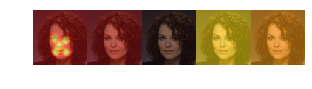

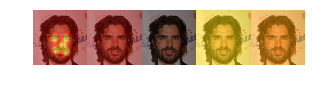

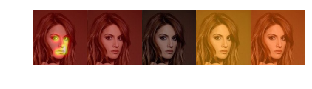

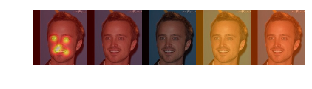

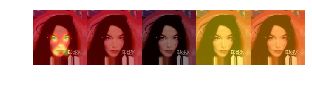

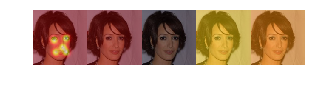

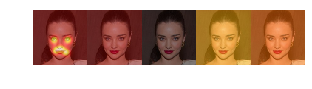

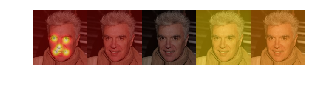

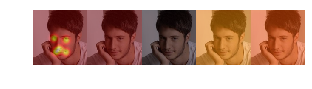

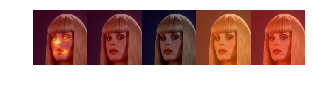

In [9]:
val_loss = []
nme_all = []
with tqdm(total=len(val_dl), desc='Epoch: [%d/%d]'%(epoch, NUM_EPOCH), miniters=1) as t:
    for i, sample in enumerate(val_dl):
        solver.feed_data(sample[:2])
        img_name = os.path.basename(sample[2][0])
        loss = solver.evaluate()
        val_loss.append(loss)
        nme = solver.calc_nme()
        nme_all.append(nme)
        if i < opt['train']['num_save_image']:
            solver.log_current_visual(img_name, tb_logger, current_step)
            solver.save_current_visual(img_name, epoch)
        t.set_postfix_str("Val Loss: %.4f, NME: %.4f" % loss, nme)
        t.update()
        if i > 20:
            break
mean_val_loss = sum(val_loss) / len(val_loss)
mean_nme /= sum(nme_all) / len(nme_all)
solver.records['val_loss'].append(mean_val_loss)
solver.records['nme'].append(mean_nme)
tb_logger.add_scalar('val loss', ean_val_loss, global_step=current_step)
tb_logger.add_scalar('nme', mean_nme, global_step=current_step)

array([[[ 32,  88],
        [ 40, 104],
        [ 60, 100],
        [124,  48],
        [ 52, 116]]])